## Importamos librerias
Paso necesario para trabajar con herramientas de python que nos permiten hacer analisis, graficas, etc.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
import geopandas as gpd
import contextily as cx
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
plt.style.use('seaborn-v0_8')

In [2]:
df = pd.read_csv("20211220_EVALUACION_DOCENTE_2020_20210707_PUBL.csv",sep=";") #Creamos dataframe con datos necesarios
df.head(5) # Visualizamos las primeras 5 filas

,AGNO_EVAL,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,NOM_DEPROV_RBD,...,ESTADO_ESTAB,MRUN,DOC_GENERO,DOC_FEC_NAC,NIVEL,PF_PJE,PF_ESC,PF_Cat_Carrera,INSTR_PJE,INSTR_ESC
0,2020,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,151,15101,ARICA,151,ARICA,...,1,2506691,1,197703,ECE,"2,79",C,B,"3,07",D
1,2020,3,5,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,151,15101,ARICA,151,ARICA,...,1,15428050,2,197306,ECE,"2,92",C,B,"3,15",D
2,2020,4,3,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,151,ARICA,...,1,11465866,2,196907,EM,"2,6",C,B,"2,66",C
3,2020,5,1,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,151,ARICA,...,1,13354326,1,196109,EM,"3,08",D,A,"3,35",D
4,2020,9,4,ESCUELA REPUBLICA DE ISRAEL,15,151,15101,ARICA,151,ARICA,...,1,6054839,2,198905,EE,"1,34",I,E,"2,2",B


## Tarea 1: Limpieza y Preparación de Datos
1.Identificación de valores faltantes: Revisa la base de datos y verifica si hay valores faltantes en las variables clave, como PF_PJE (Puntaje Portafolio) o INSTR_PJE (Puntaje Final en base a resultados en instrumentos). Si encuentras valores faltantes, decide cómo manejarlos (eliminación, imputación, etc.).

2.Normalización de datos: Asegúrate de que todas las variables numéricas estén en el formato correcto (por ejemplo, fechas en formato AAAAMMDD). Si es necesario, convierte las variables categóricas a factores o códigos numéricos.

In [3]:
df['PF_PJE'] = df['PF_PJE'].str.replace(',', '.').astype(float)
df['INSTR_PJE'] = pd.to_numeric(df['INSTR_PJE'].str.replace(',', '.').str.strip(),errors='coerce')
df = df[df['INSTR_PJE'] != -1]
df = df.dropna()

In [4]:
regiones_key = {
    1: 'Tarapacá',
    2: 'Antofagasta', 
    3: 'Atacama',
    4: 'Coquimbo',
    5: 'Valparaíso',
    6: "Libertador General Bernardo O'Hi",
    7: 'Maule',
    8: 'Bío-Bío',
    9: 'Araucanía',
    10: 'Los Lagos',
    11: 'Aysén del General Ibañez del Cam',
    12: 'Magallanes y Antártica Chilena',
    13: 'Santiago Metropolitan',
    14: 'Los Ríos',
    15: 'Arica y Parinacota',
    16: 'Ñuble'
}

df['NOM_REG'] = df['COD_REG_RBD'].map(regiones_key) # Creamos una nueva columna para colocar los nombres de cada region, trabajo previo para 
                                                    # poder hacer un join con data de geopandas

del regiones_key

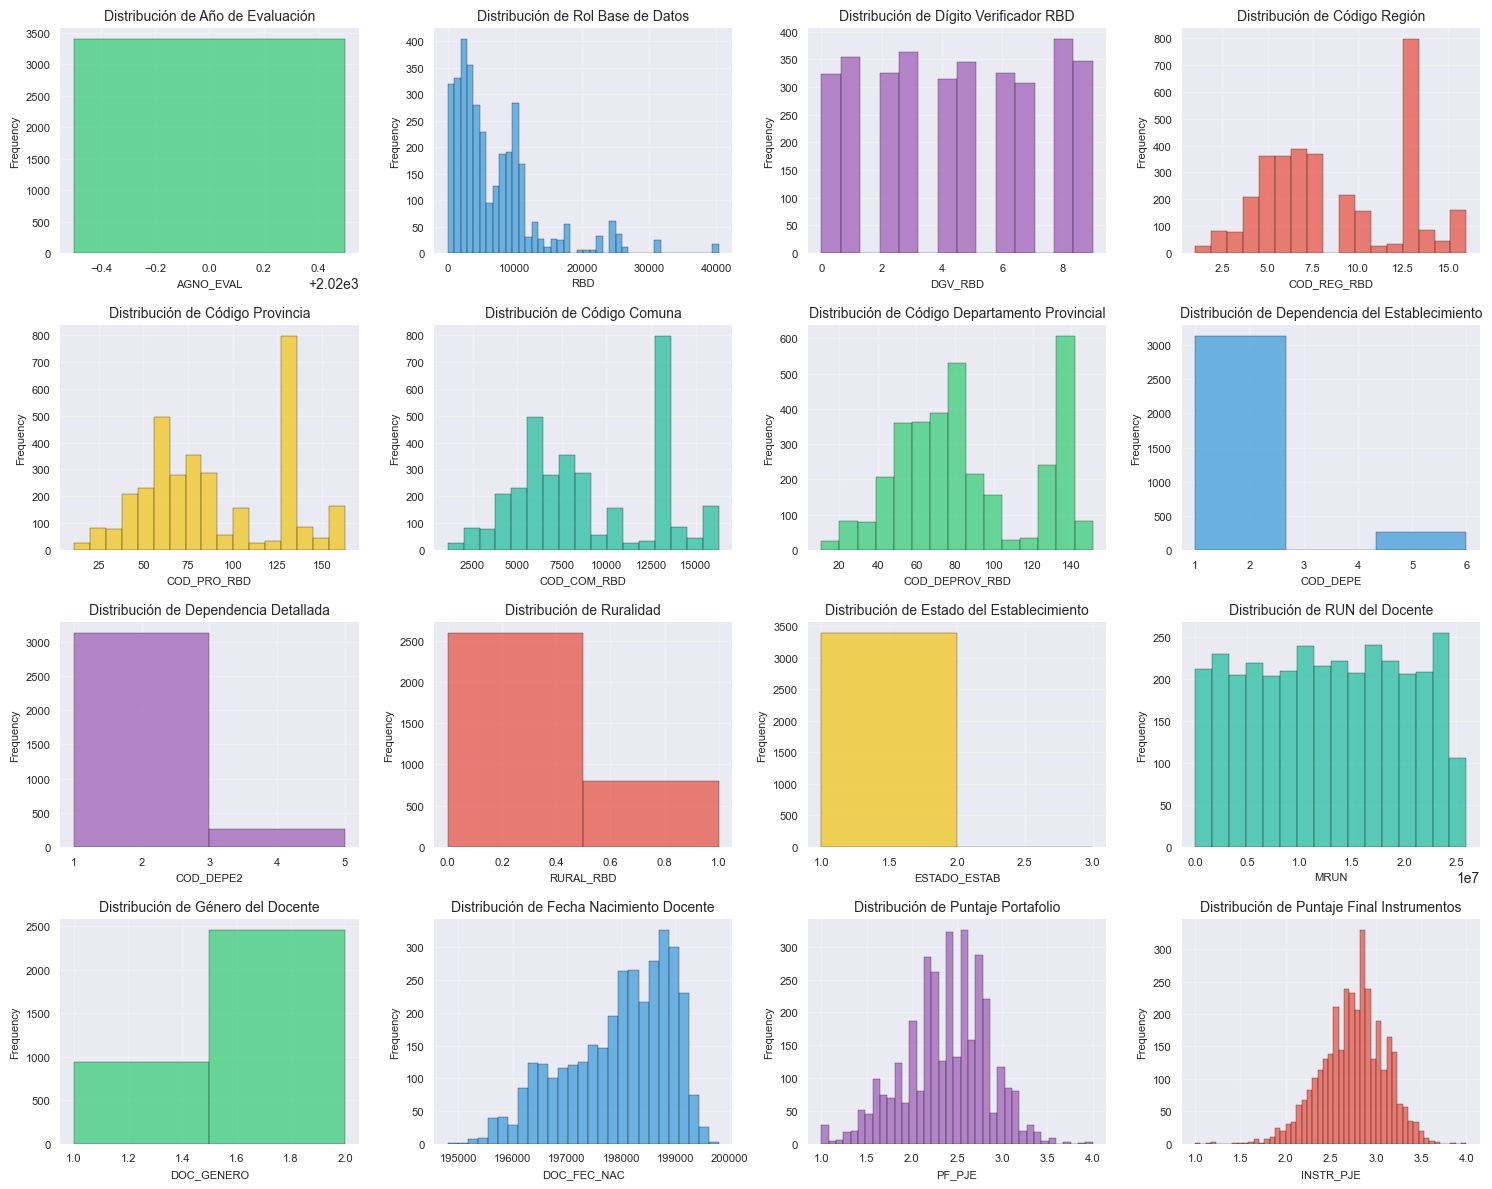

In [5]:
names = {
    'AGNO_EVAL': 'Año de Evaluación',
    'RBD': 'Rol Base de Datos',
    'DGV_RBD': 'Dígito Verificador RBD',
    'NOM_RBD': 'Nombre del Establecimiento',
    'COD_REG_RBD': 'Código Región',
    'COD_PRO_RBD': 'Código Provincia',
    'COD_COM_RBD': 'Código Comuna',
    'NOM_COM_RBD': 'Nombre Comuna',
    'COD_DEPROV_RBD': 'Código Departamento Provincial',
    'NOM_DEPROV_RBD': 'Nombre Departamento Provincial',
    'COD_DEPE': 'Dependencia del Establecimiento',
    'COD_DEPE2': 'Dependencia Detallada',
    'RURAL_RBD': 'Ruralidad',
    'ESTADO_ESTAB': 'Estado del Establecimiento',
    'MRUN': 'RUN del Docente',
    'DOC_GENERO': 'Género del Docente',
    'DOC_FEC_NAC': 'Fecha Nacimiento Docente',
    'NIVEL': 'Nivel de Enseñanza',
    'PF_PJE': 'Puntaje Portafolio',
    'PF_ESC': 'Nivel de Desempeño Portafolio',
    'PF_Cat_Carrera': 'Categoría Carrera Docente',
    'INSTR_PJE': 'Puntaje Final Instrumentos',
    'INSTR_ESC': 'Nivel Final Instrumentos'
}
# Creamos un grafico con subplots para cada columna con datos numericos (16 columnas)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))

# Genera una lista 1D con los nombres para facilitar iteraciones
axes = axes.ravel()

# Seleccionamos solo las columnas numericas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Seleccionamos colores personalizados
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c']

# Graficamos cada columna con una configuracion en particular (aleatoria)
for idx, col in enumerate(numeric_cols):
    if idx < len(axes):  # Para no tener errores de indices
        # configuramos la cantidad de bins para cada histograma
        if df[col].nunique() < 10:
            bins = df[col].nunique()
        else:
            bins = 'auto'
            
        # Creamos el histograma
        df[col].hist(ax=axes[idx], 
                    bins=bins,
                    color=colors[idx % len(colors)],
                    alpha=0.7,
                    edgecolor='black')
        
        # Personalizamos los histogramas
        title = names.get(col, col)
        axes[idx].set_title(f'Distribución de {title}', fontsize=10)
        axes[idx].set_xlabel(col, fontsize=8)
        axes[idx].set_ylabel('Frequency', fontsize=8)
        axes[idx].tick_params(labelsize=8)
        axes[idx].grid(True, alpha=0.3)

# Quitamos histogramas vacios en caso de existir
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

# Ajustamos el layout
plt.tight_layout()
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()
del names, axes, colors


# Limpieza y Preparación de Datos de Evaluación Docente

De acuerdo a la información dada por el pdf, analizamos el tipo de dato de cada columna, identificando tres casos principales:

1. **Columna faltante**: En el archivo CSV no existe la columna 'NOM_REG_RBD_A' mencionada en el PDF.

2. **Discrepancia de tipo de dato**: La columna 'NIVEL' debería ser numérica según la documentación, pero está como texto. No se modificará ya que no afecta nuestro análisis.

3. **Columnas numéricas almacenadas como texto**: Las columnas 'PF_PJE' y 'INSTR_PJE' requirieron conversión.

Para la columna 'PF_PJE':
- Se reemplazó la coma por punto decimal usando `str.replace(',', '.')`
- Se convirtió al tipo float con `astype(float)`

Para la columna 'INSTR_PJE':
- Se reemplazó la coma por punto decimal con `str.replace(',', '.')`
- Se eliminaron espacios en blanco con `str.strip()`
- Se convirtió a tipo numérico con `pd.to_numeric(..., errors='coerce')` para manejar valores problemáticos como NaN

En la columna 'INSTR_PJE' se identificaron valores en {-1} ∪ (1,4). Los valores -1 corresponden a docentes de colegios particulares, que fueron excluidos del análisis mediante `df = df[df['INSTR_PJE'] != -1]`.

Finalmente, se eliminaron todas las filas con valores NaN usando `df.dropna()`.

## Tarea 2: Análisis Exploratorio de Datos (EDA)

1. Distribución de puntajes: Realiza un análisis de la distribución de los puntajes de los docentes en las variables PF_PJE y INSTR_PJE. Usa histogramas o gráficos de densidad para visualizar la distribución.
2. Comparación por género: Analiza si hay diferencias significativas en los puntajes de evaluación entre docentes de diferentes géneros (DOC_GENERO). Puedes usar pruebas estadísticas como la prueba t o ANOVA, dependiendo de la distribución de los datos.
3. Análisis por región: Agrupa los datos por región (COD_REG_RBD) y compara los puntajes promedio de los docentes en cada región. Visualiza los resultados usando un gráfico de barras o un mapa geográfico.

In [6]:
print(df[['PF_PJE','INSTR_PJE']].describe()) # .describe() nos muestra caracteristicas relevantes de las variables seleccionadas
                                             # en este caso estmos interesados en el promedio, la desviacion estandar, IQ1, IQ3 y el maximo 

            PF_PJE    INSTR_PJE
count  3397.000000  3397.000000
mean      2.383868     2.751404
std       0.467872     0.350532
min       1.000000     1.000000
25%       2.100000     2.530000
50%       2.430000     2.770000
75%       2.710000     2.980000
max       4.000000     4.000000


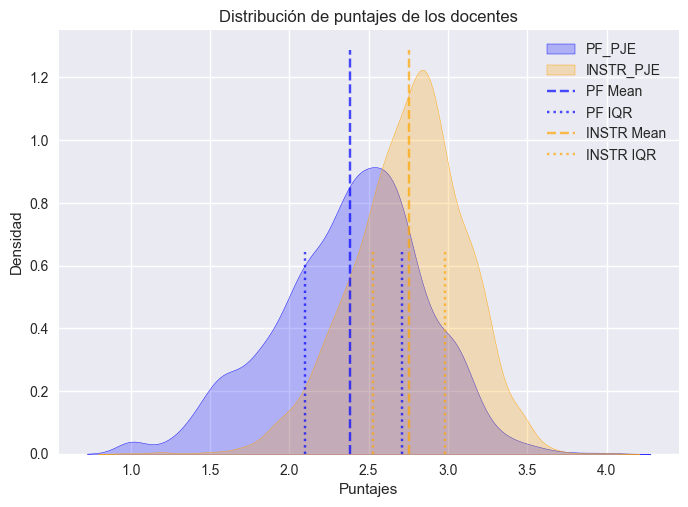

In [7]:
# Creamos ambos graficos de densidad
pf_density = sns.kdeplot(df['PF_PJE'], label='PF_PJE', fill=True, color='blue')
instr_density = sns.kdeplot(df['INSTR_PJE'], label='INSTR_PJE', fill=True, color='orange')

# Seteamos los limites del eje y para indicar las medias y el IQR
ymin, ymax = plt.ylim()

# Calculamos IQR de ambas distruiciones
pf_q1, pf_q3 = df['PF_PJE'].quantile([0.25, 0.75])
instr_q1, instr_q3 = df['INSTR_PJE'].quantile([0.25, 0.75])

# Dibujamos las lineas de medias y IQR
plt.vlines(x=df['PF_PJE'].mean(), ymin=0, ymax=ymax, 
           color='blue', linestyle='--', alpha=0.7, label='PF Mean')
plt.vlines([pf_q1, pf_q3], ymin=0, ymax=ymax/2,
           color='blue', linestyle=':', alpha=0.7, label='PF IQR')

plt.vlines(x=df['INSTR_PJE'].mean(), ymin=0, ymax=ymax,
           color='orange', linestyle='--', alpha=0.7, label='INSTR Mean')
plt.vlines([instr_q1, instr_q3], ymin=0, ymax=ymax/2,
           color='orange', linestyle=':', alpha=0.7, label='INSTR IQR')

# Agregamos etiquetas y titulo
plt.xlabel('Puntajes')
plt.ylabel('Densidad')
plt.title('Distribución de puntajes de los docentes')
plt.legend()
plt.show()

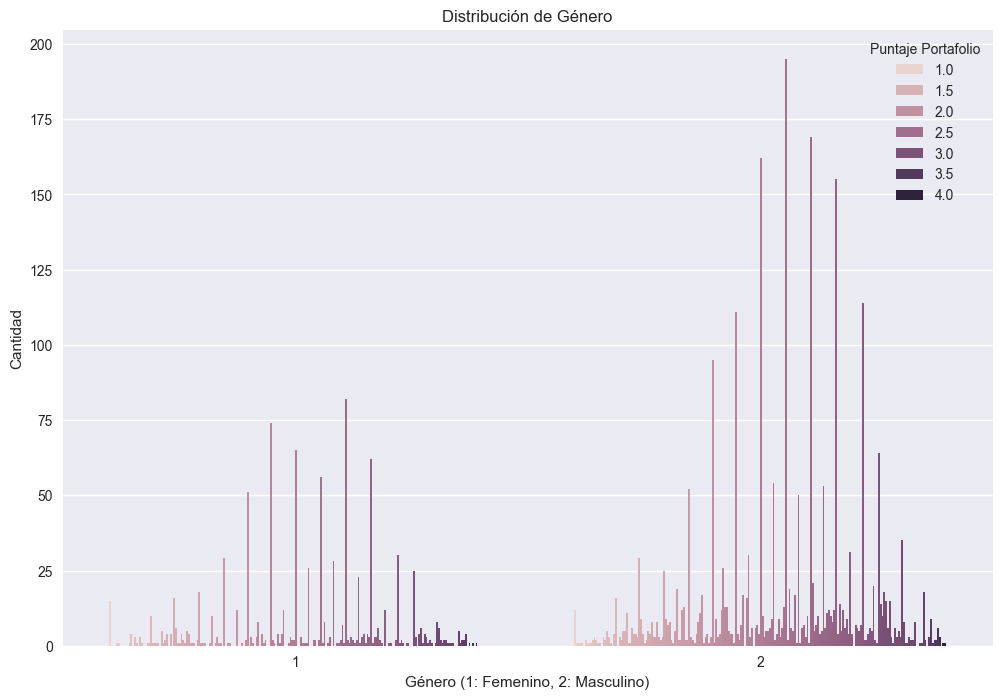

In [8]:
# Creamos un histograma que nos muestre el Puntaje Final del Portafolio por Género
plt.figure(figsize=(12,8))
sns.countplot(data = df, x = 'DOC_GENERO', hue='PF_PJE')

# Agregamos etiquetas y título
plt.title('Distribución de Género')
plt.xlabel('Género (1: Femenino, 2: Masculino)')
plt.ylabel('Cantidad')
plt.legend(title='Puntaje Portafolio')
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()

In [9]:
# Creamos 2 nuevos DataFrames para implementar el t-test para los generos 1 y 2 y para los puntajes de portafolio
df_genero_1 = df[df['DOC_GENERO'] == 1]['PF_PJE']
df_genero_2 = df[df['DOC_GENERO'] == 2]['PF_PJE']

t_statistic,p_value = ttest_ind(df_genero_1,df_genero_2)

print(f"Estadístico t: {t_statistic}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre los grupos.")
else:
    print("No rechazamos la hipótesis nula: no hay una diferencia significativa entre los grupos.")

del df_genero_1, df_genero_2  # Eliminamos las variables para liberar memoria

Estadístico t: -3.9431250131364703
Valor p: 8.205013539834506e-05
Rechazamos la hipótesis nula: hay una diferencia significativa entre los grupos.


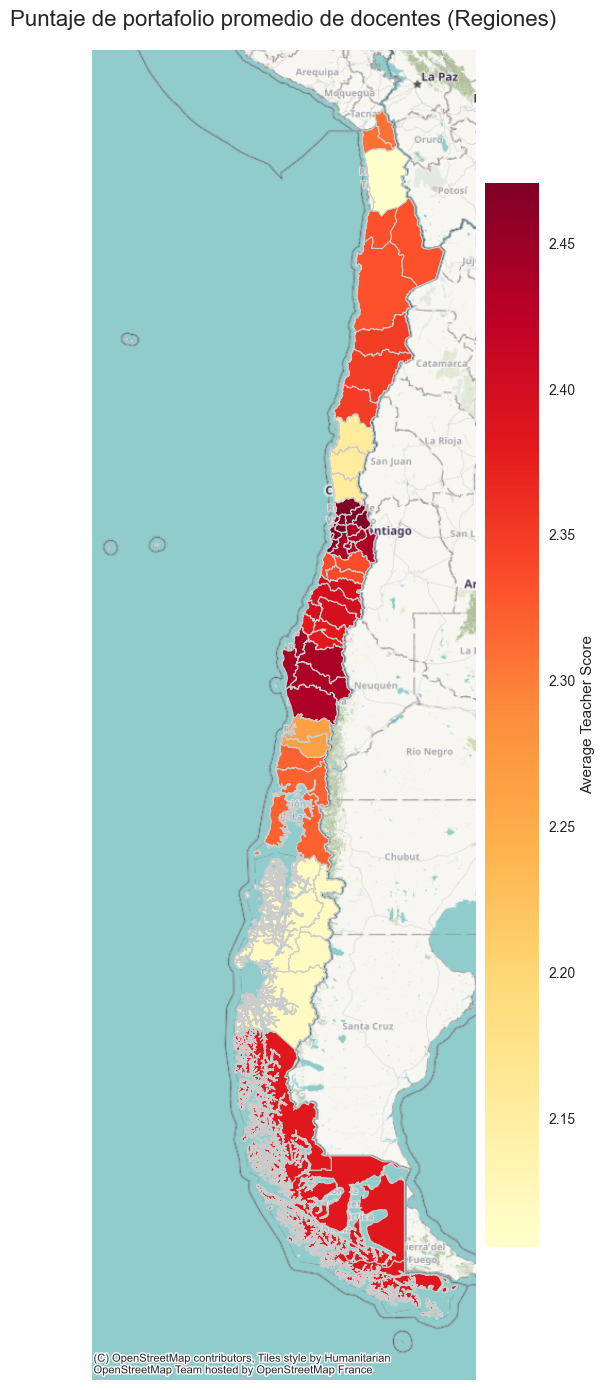

In [10]:
# Cargamos el mapa de Chile por regiones (gadm41_CHL_1.shp), pero por cuestiones esteticas (eliminar isla de pascua para que el mapa
# no quede tan desenfocado) ocuparemos el mapa por provincias (gadm41_CHL_2.shp)
chile_reg = gpd.read_file('Mapa_chile/gadm41_CHL_2.shp') 

# Calculamos el promedio del puntaje de portafolio por regiones 
reg_scores = df.groupby('NOM_REG')['PF_PJE'].mean().reset_index()

# Juntamos la data por regiones (NAME_1 son la regiones del archivo .shp y NOM_REG son las regiones 
# del dataframe original, obtenido por el .csv)
chile_map_reg = chile_reg.merge(reg_scores, left_on='NAME_1', right_on='NOM_REG', how='left')

# Eliminamos isla de pascua xd (por la visualizacion, queda un mapa extraño) (el idx de isla de pascua por provincias es idx = 47)
# Vemos en el DataFrame que hay 5 valores relacionados con Isal de Pacua, sin embargo por temas esteticos no los contaremos, se juntaran 
# en la Quinta región
chile_map_reg.drop(47, inplace = True)

# Creamos el mapa 
df_aux = chile_map_reg.to_crs(epsg=3857)
fig, ax = plt.subplots(1, 1, figsize=(6, 14))
ax = df_aux.plot(column='PF_PJE', kind='geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
               legend_kwds={'label': 'Average Teacher Score', 'orientation': 'vertical', 'shrink': 0.8, 'pad': 0.02})

# Quitamos los ejes
ax.axis('off')

# Agregamos el titulo
plt.title('Puntaje de portafolio promedio de docentes (Regiones)', fontsize=16)
# Agregamos un background de mapa
cx.add_basemap(ax)
plt.tight_layout()
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()

del chile_reg, reg_scores, chile_map_reg,df_aux # eliminamos las variables para liberar memoria

## Tarea 3: Análisis de Correlación
1. Correlación entre variables: Calcula la correlación entre las variables PF_PJE y INSTR_PJE. ¿Existe una relación significativa entre el puntaje del portafolio y el puntaje final de los instrumentos? Usa un gráfico de dispersión para visualizar esta relación.
2. Correlación por nivel educativo: Analiza si el nivel educativo (NIVEL) tiene algún impacto en los puntajes de evaluación. ¿Los docentes de ciertos niveles tienden a obtener puntajes más altos o más bajos?

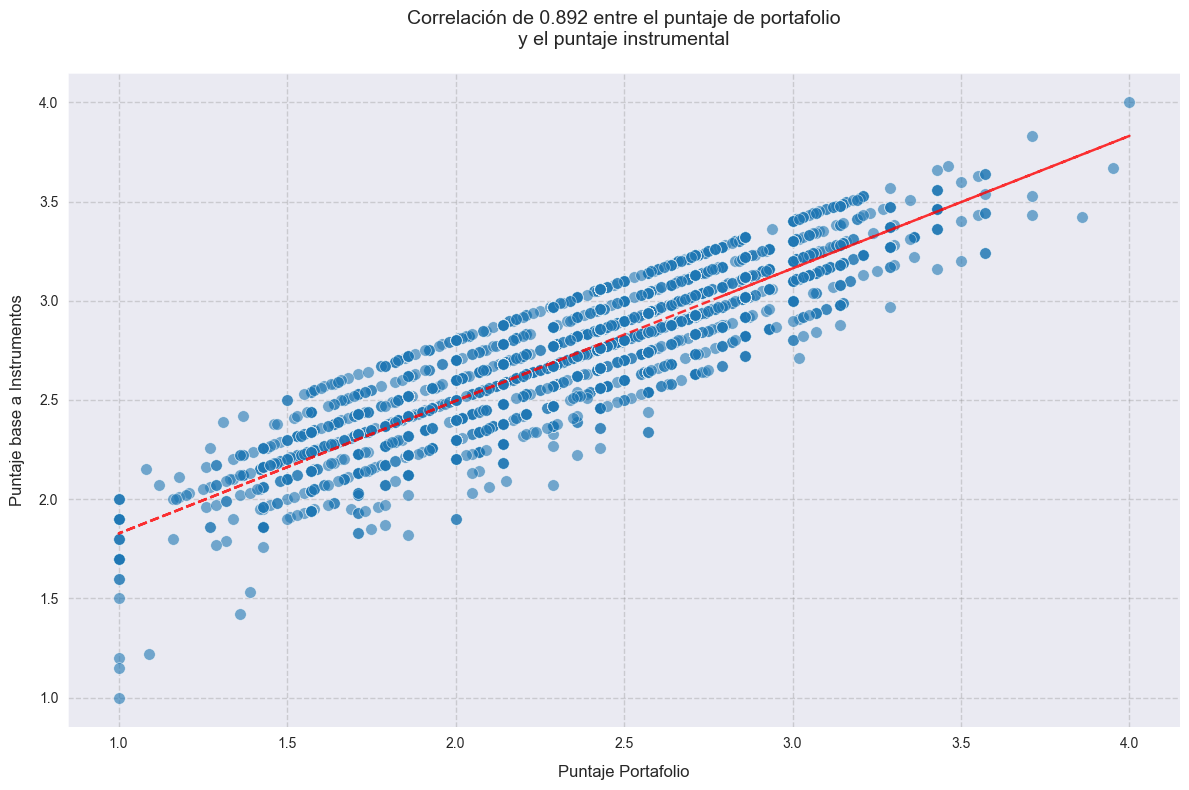

In [11]:
plt.figure(figsize=(12, 8), facecolor='white')
# calculamos la correlación de ambas variables y la guardamos en la variable 'correlacion'
correlacion = df['PF_PJE'].corr(df['INSTR_PJE'])

# Creamos el gráfico de dispersión
scatter = plt.scatter(df['PF_PJE'], 
                     df['INSTR_PJE'],
                     c='#1f77b4', 
                     alpha=0.6,
                     s=70,
                     edgecolor='white',
                     linewidth=0.5)

# agregamos una línea de tendencia
z = np.polyfit(df['PF_PJE'], df['INSTR_PJE'], 1)
p = np.poly1d(z)
plt.plot(df['PF_PJE'], p(df['PF_PJE']), "r--", alpha=0.8)

# Personalizamos el gráfico
plt.title(f'Correlación de {correlacion:.3f} entre el puntaje de portafolio\ny el puntaje instrumental', 
          fontsize=14, 
          pad=20)
plt.xlabel('Puntaje Portafolio', fontsize=12, labelpad=10)
plt.ylabel('Puntaje base a Instrumentos', fontsize=12, labelpad=10)

# mejoramos la apariencia de los ejes
plt.grid(True, linestyle='--', alpha=0.3, color='gray')
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

# Ajustamos el layout y guardamos la figura
plt.tight_layout()
plt.savefig('Images/' + plt.gca().get_title().replace('\n', ' ') + '.png', 
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [12]:
grupos = [df[df['NIVEL'] == categoria]['PF_PJE'] for categoria in df['NIVEL'].unique()]
f_statistic, p_value = f_oneway(*grupos)
print(f"F-statistic: {f_statistic}, p-value: {p_value}")
del grupos

F-statistic: 12.845539505656994, p-value: 2.743856705120863e-22


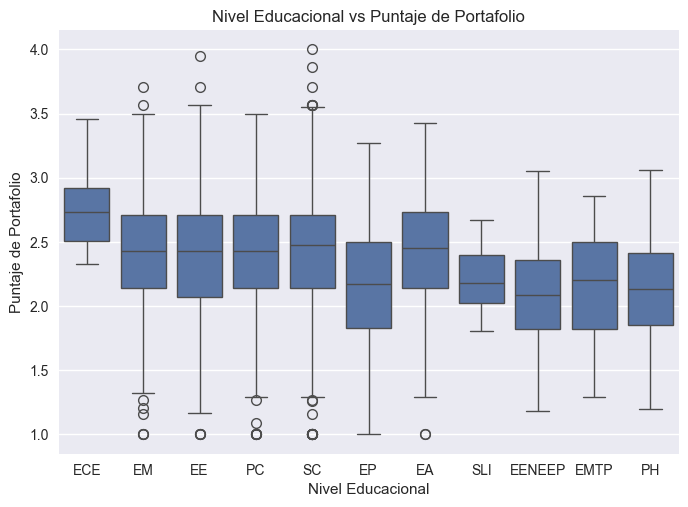

In [13]:
# Creamos un boxplot para ver la tendencia de los nivels v/s el puntaje de portafolio
sns.boxplot(x='NIVEL', y='PF_PJE', data=df)

# Agregamos etiquetas y título
plt.title('Nivel Educacional vs Puntaje de Portafolio')
plt.xlabel('Nivel Educacional')
plt.ylabel('Puntaje de Portafolio')
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()

## Tarea 4: Visualización de Datos
1. Gráficos de tendencia temporal: Crea un gráfico de línea que muestre la evolución del número de observaciones (Número de observaciones) a lo largo de los años (desde 2012 hasta 2022). ¿Hay algún patrón o tendencia que llame
la atención?
2. Mapa de calor por región: Usa un mapa de calor para visualizar los puntajes promedio de los docentes en cada región. Esto te permitirá identificar regiones con puntajes más altos o más bajos.

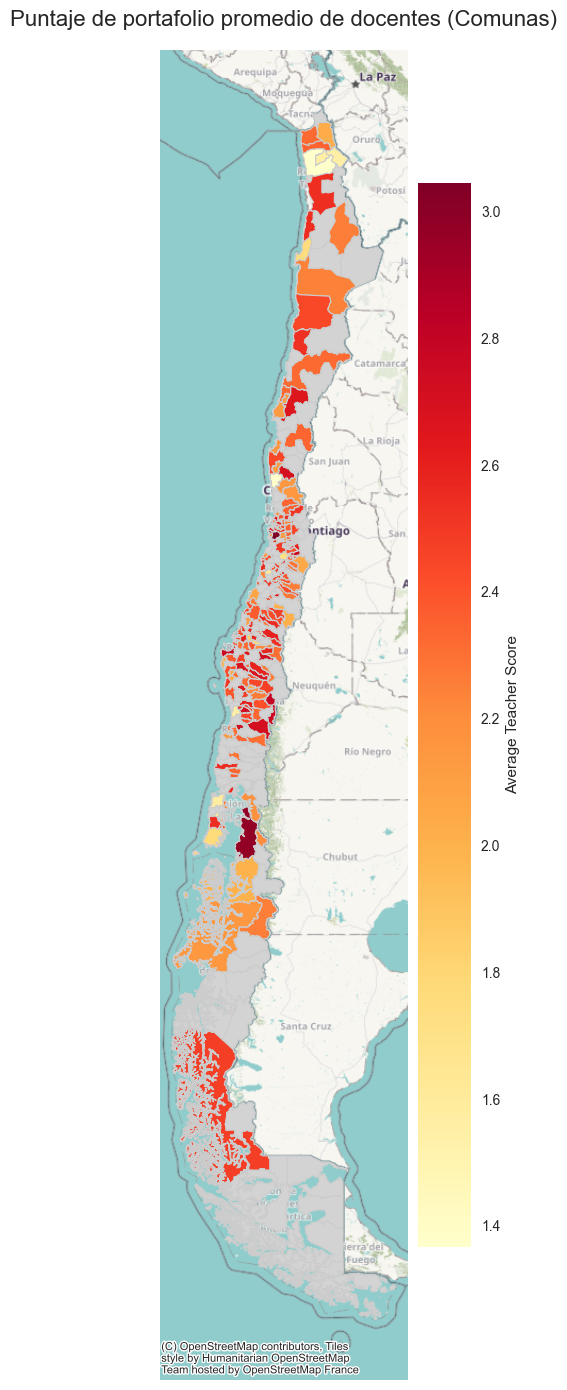

In [14]:
# Cargamos el mapa de chile por comunas
chile_com = gpd.read_file('Mapa_chile/gadm41_CHL_3.shp')

# Calculamos el puntaje promedio de portafolio por comuna
com_scores = df.groupby('NOM_COM_RBD')['PF_PJE'].mean().reset_index()

# la diferencia de nombres entre el mapa y los datos nos fuerza a 
# implementar la funcion .capitalize() para poder hacer Merge entre los datos
com_scores['NOM_COM_RBD'] = com_scores['NOM_COM_RBD'].str.capitalize()

# Juntamos la data del mapa y de los puntajes d eportafolio
chile_map_com = chile_com.merge(com_scores, left_on='NAME_3', right_on='NOM_COM_RBD', how='left')


#Quitamos Juan Fernandez (idx = 307) y a  Isla de Pascua (idx = 340)

chile_map_com.drop([307, 340], inplace = True)
# Creamos el mapa
df_aux = chile_map_com.to_crs(epsg=3857)
fig, ax = plt.subplots(1, 1, figsize=(6, 14))
ax = df_aux.plot(column='PF_PJE', kind='geo', cmap='YlOrRd', linewidth=0.8, edgecolor='.8', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, 
               legend_kwds={'label': 'Average Teacher Score', 'orientation': 'vertical', 'shrink': 0.8, 'pad': 0.02})

# Quitamos los ejes
ax.axis('off')

# Agregamos titulo
plt.title('Puntaje de portafolio promedio de docentes (Comunas)', fontsize=16)
# Agregamos un background de mapa
cx.add_basemap(ax)
plt.tight_layout()
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()
del chile_com, com_scores, chile_map_com, df_aux


## Tarea 5: Análisis de Agrupamiento (Clustering)
1. Agrupamiento por puntajes: Usa técnicas de clustering (como K-Means) para agrupar a los docentes en función de sus puntajes en PF_PJE y INSTR_PJE. ¿Puedes identificar grupos de docentes con perfiles de evaluación similares?
2. Análisis de grupos por región: Una vez que hayas identificado los grupos, analiza si hay regiones que tengan una mayor proporción de docentes en ciertos grupos. ¿Hay regiones que tienden a tener docentes con puntajes más altos o más bajos?

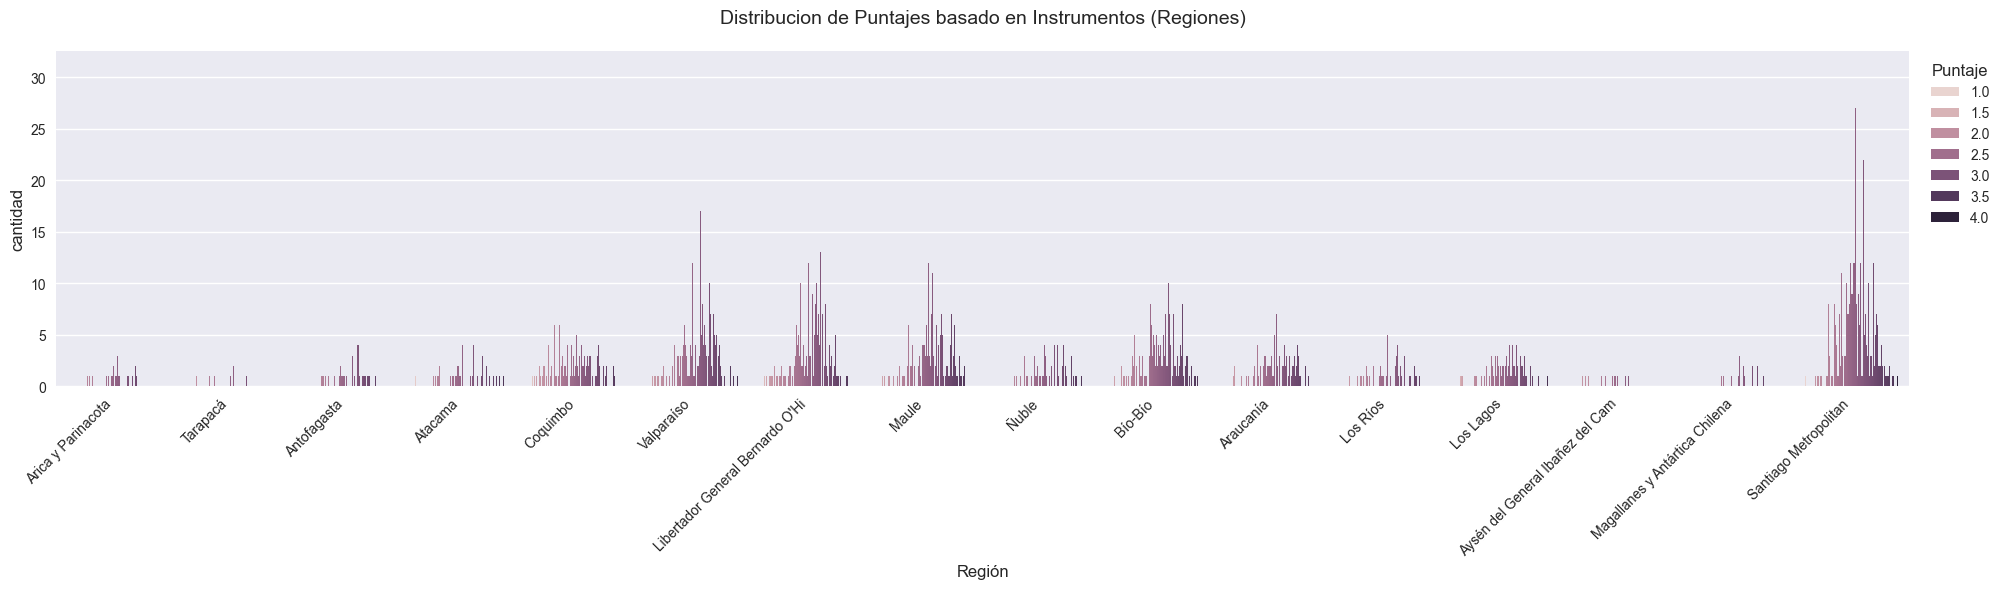

In [15]:
# Creamos un histograma que muestre la distribución de los puntajes de los instrumentos en cada región.
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='NOM_REG', hue='INSTR_PJE')

# Agregamos titulos y etiquetas
plt.title('Distribucion de Puntajes basado en Instrumentos (Regiones)', fontsize=14, pad=20)
plt.xlabel('Región', fontsize=12)
plt.ylabel('cantidad', fontsize=12)

# Configuramos los nombres de la regiones para que sea entendible (y no se sobrepongan)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Puntaje', title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.savefig('Images/' + plt.gca().get_title() + '.png')
plt.show()


## Tarea 6: Interpretación y Reporte
1. Interpretación de resultados: Escribe un breve informe interpretando los resultados de tus análisis. ¿Qué conclusiones puedes sacar sobre la evaluación docente en Chile? ¿Hay áreas que necesiten mejora o que estén destacando positivamente?
2. Recomendaciones: Basado en tus hallazgos, propone recomendaciones para mejorar el sistema de evaluación docente. Por ejemplo, si encuentras que ciertas regiones tienen puntajes más bajos, ¿qué acciones podrían tomarse para mejorar la calidad de la enseñanza en esas áreas?

## Tarea 7: Análisis de Datos Longitudinales (Opcional)
1. Tendencia de puntajes a lo largo del tiempo: Si tienes acceso a datos históricos, analiza cómo han cambiado los puntajes de evaluación a lo largo de los años. ¿Ha habido una mejora o un deterioro en los puntajes de los docentes?
2. Impacto de políticas educativas: Investiga si hubo cambios en las políticas educativas que puedan haber influido en los puntajes de evaluación. Por ejemplo, ¿hubo alguna reforma educativa que coincida con cambios en los puntajes?